<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-03-tree-based-models-bagging-grf-causal-survival-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.3 Causal Survival Forest (CSF)

This notebook demonstrates how to use the **Causal Survival Forest (CSF)** from the `{grf}` package in R to estimate heterogeneous treatment effects on survival data, particularly when outcomes are right-censored. The example uses the `lung` dataset, which contains survival data for patients with advanced lung cancer.

## Overview

A **Causal Survival Forest (CSF)** is designed to estimate **heterogeneous treatment effects** for survival data, particularly when outcomes are right-censored. It extends the concept of causal forests to handle time-to-event data, enabling researchers to estimate how a treatment impacts survival outcomes across different subgroups defined by covariates, without relying on restrictive parametric assumptions. CSFs are useful in fields like medicine, economics, and social sciences, where understanding how treatments affect survival outcomes across diverse populations is critical (e.g., estimating the effect of a drug on patient survival based on age, sex, or disease severity).



### Key Concepts of Causal Survival Forests

1.  `Heterogeneous Treatment Effects`: CSFs estimate the **conditional average treatment effect (CATE)**, denoted as $\tau(X)$, which varies across individuals based on their covariate profile $X$. For survival data, this effect can be defined in two ways:

-   `Restricted Mean Survival Time (RMST)`: $\tau(X) = E[\min(T(1), h) - \min(T(0), h) | X = x]$, where $T(1)$ and $T(0)$ are the potential survival times under treatment and control, respectively, and $h$ is a specified time horizon.

-   `Survival Probability`: $\tau(X) = P[T(1) \> h \| X = x] - P[T(0) \> h \| X = x$, which compares the probability of surviving past time $h$ under treatment versus control.

2.  `Right-Censoring`: Survival data often involves censoring, where the event time is not observed for all subjects. CSFs account for this by incorporating ensoring indicators and using techniques like inverse probability of censoring weighting (IPCW).

3.  `Non-parametric Approach`: Unlike traditional survival models (e.g., Cox proportional hazards), CSFs are non-parametric, making them flexible for capturing complex, non-linear relationships between covariates and treatment effects.

4.  `Forest-Based Estimation`: CSFs build an ensemble of trees, where each tree splits the covariate space to maximize heterogeneity in treatment effects. Predictions are made by aggregating estimates across trees, weighted by how often a test sample falls into the same leaf as training samples.

5.  `Honest Estimation`: The `grf` package uses "honest" estimation, splitting the data into subsets for choosing tree splits and populating leaf estimates, reducing overfitting.

6.  `Applications`: CSFs are useful in fields like medicine, economics, and social sciences, where understanding how treatments affect survival outcomes across diverse populations is critical (e.g., estimating the effect of a drug on patient survival based on age, sex, or disease severity).

### How CSFs Work

1.  Input Data

-   $X$: Covariates (e.g., age, sex, clinical measurements).

-   $Y$: Observed time (minimum of event time and censoring time).

-   $W$: Treatment assignment (binary or continuous).

-   $D$: Censoring indicator (1 if the event is observed, 0 if censored).

-   $h$: Time horizon for RMST or survival probability.

2.  Splitting Criterion

-   Trees are grown by maximizing the difference in treatment effects between child nodes, using a modified objective that accounts for censoring (e.g., via AIPW scores, as described in Cui et al., 2023).

3.  Prediction

-   For a given covariate profile (X = x), the forest estimates $\tau(x)$ by averaging treatment effect estimates from trees, using weights based on sample: CSFs use techniques like IPCW or survival forests to estimate censoring probabilities, ensuring unbiased treatment effect estimates.


### How does it differ from Causal Forest and Survival Forest?



| **Aspect**                | **Survival Forest**                              | **Causal Forest**                              | **Causal Survival Forest**                     |
|---------------------------|--------------------------------------------------|-----------------------------------------------|-----------------------------------------------|
| `Objective`             | Predict survival probability or hazard over time | Estimate heterogeneous treatment effects       | Estimate treatment effects on survival outcomes |
| `Outcome Type`          | Time-to-event (censored)                        | Continuous or binary                          | Time-to-event (censored)                      |
| `Treatment Variable`    | None                                            | Required (W: 0/1)                            | Required (W: 0/1)                             |
| `Inputs`                | X, Y, D                                         | X, Y, W                                      | X, Y, D, W                                    |
| `Output`                | Survival curves or hazard functions             | Treatment effect estimates $\tau(X)$)      | Treatment effect on survival $\tau(t | X)$ |
| `Use Case`              | Survival prediction (e.g., patient prognosis)   | Treatment effect heterogeneity (e.g., drug impact) | Treatment effect on survival (e.g., therapy impact) |
| `Assumptions`           | Handles censoring                               | Unconfoundedness, overlap                    | Unconfoundedness, overlap, censoring handled  |
| `{grf} Function`        | `survival_forest()`                             | `causal_forest()`                            | `causal_survival_forest()`                    |


### Practical Notes

- `Survival Forest`: Used when the goal is purely predictive (e.g., forecasting patient survival based on covariates). It does not involve a treatment variable.

- `Causal Forest`: Used for non-survival outcomes (e.g., blood pressure, test scores) to understand how treatment effects vary across individuals.

`Causal Survival Forest`: Used when both treatment effects and survival outcomes are of interest, combining the strengths of the other two models.


## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.17
Uninstalling rpy2-3.5.17:
  Successfully uninstalled rpy2-3.5.17
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314976 sha256=6fa19e9a1a1c85c4e5633c6d411ac6e923ac0d751ff12604e7ee097909afe83c
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Causal Survival Forest with R

The `grf` package in R provides an implementation of Causal Survival Forests (CSF) that allows for the estimation of heterogeneous treatment effects on survival data, accounting for right-censoring. The CSF can be used to estimate the average treatment effect (ATE) and to assess treatment effect heterogeneity across different covariate profiles.




### Load and Check Required Libraries

In [3]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'survival',
              'mlbench',
              'Metrics')

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [4]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:Metrics"   "package:mlbench"   "package:survival" 
 [4] "package:grf"       "package:plyr"      "package:lubridate"
 [7] "package:forcats"   "package:stringr"   "package:dplyr"    
[10] "package:purrr"     "package:readr"     "package:tidyr"    
[13] "package:tibble"    "package:ggplot2"   "package:tidyverse"
[16] "package:tools"     "package:stats"     "package:graphics" 
[19] "package:grDevices" "package:utils"     "package:datasets" 
[22] "package:methods"   "package:base"     


### Load and Explore the Lung Dataset

The `lung` dataset contains survival data for 228 patients with advanced lung cancer.


In [5]:
%%R
# Load the lung dataset
data(lung)
# Check for NAs in key variables
cat("NAs in time:", sum(is.na(lung$time)), "\n")
cat("NAs in status:", sum(is.na(lung$status)), "\n")
head(lung)

NAs in time: 0 
NAs in status: 0 
  inst time status age sex ph.ecog ph.karno pat.karno meal.cal wt.loss
1    3  306      2  74   1       1       90       100     1175      NA
2    3  455      2  68   1       0       90        90     1225      15
3    3 1010      1  56   1       0       90        90       NA      15
4    5  210      2  57   1       1       90        60     1150      11
5    1  883      2  60   1       0      100        90       NA       0
6   12 1022      1  74   1       1       50        80      513       0


### Prepare the Data

Rows after removing NAs: 168 
Number of events (D=1):
D
  0   1 
 47 121 
Summary of event times where event observed:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    5.0   147.0   246.0   289.1   426.0   814.0 
Using horizon = 814 


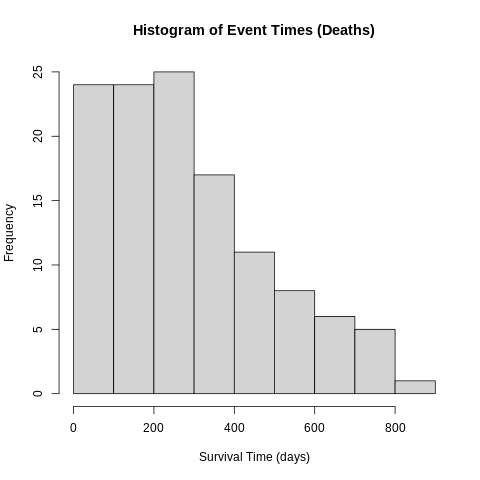

In [6]:
%%R
covar_names <- c("age", "ph.ecog", "ph.karno", "pat.karno", "meal.cal", "wt.loss")
lung2 <- lung[complete.cases(lung[, c("time", "status", "sex", covar_names)]), ]
cat("Rows after removing NAs:", nrow(lung2), "\n")

# Prepare variables for grf
Y <- lung2$time
D <- ifelse(lung2$status == 2, 1, 0)   # 1=event(death), 0=censored
W <- ifelse(lung2$sex == 2, 1, 0)      # 1=female, 0=male (treatment: female)
X <- as.matrix(lung2[, covar_names])

# Check distribution of events and event times
cat("Number of events (D=1):\n")
print(table(D))
cat("Summary of event times where event observed:\n")
print(summary(Y[D == 1]))
hist(Y[D == 1], main="Histogram of Event Times (Deaths)", xlab="Survival Time (days)")

# Find a valid horizon (latest time with at least one event)
event_times <- sort(unique(Y[D == 1]))
for (ht in event_times) {
  n_events <- sum(D == 1 & Y <= ht)
  if (n_events > 0) {
    last_valid_ht <- ht
  }
}
cat("Using horizon =", last_valid_ht, "\n")

### Split Data into Training and Test Sets

In [7]:
%%R
# Split data into training (80%) and test (20%) sets
train_prop <- 0.8
n <- nrow(lung2)
# train data
train_idx <- sample(1:n, size = round(train_prop * n))
X_train <- X[train_idx, , drop = FALSE]
Y_train <- Y[train_idx]
W_train <- W[train_idx]
D_train <- D[train_idx]
# test data
X_test <- X[-train_idx, , drop = FALSE]
Y_test <- Y[-train_idx]
W_test <- W[-train_idx]
D_test <- D[-train_idx]

cat("Training set size:", nrow(X_train), "\n")
cat("Test set size:", nrow(X_test), "\n")
cat("Column names of X_train:", colnames(X_train), "\n")

Training set size: 134 
Test set size: 34 
Column names of X_train: age ph.ecog ph.karno pat.karno meal.cal wt.loss 


### Train the Causal Survival Forest

Fit a CSF to estimate treatment effects on RMST with valid horizon.

In [8]:
%%R
# Fit the Causal Survival Forest
csf_model <- causal_survival_forest(
  X = X_train,
  Y = Y_train,
  W = W_train,
  D = D_train,
  num.trees = 1000,
  sample.fraction = 0.5,
  mtry = min(ceiling(sqrt(ncol(X_train))), ncol(X_train)/3),
  min.node.size = 5,
  honesty = TRUE,
  honesty.fraction = 0.5,
  ci.group.size = 2,
  alpha = 0.05,
  imbalance.penalty = 0,
  stabilize.splits = TRUE,
  tune.parameters = "all",
  horizon = last_valid_ht,  # Set the horizon for survival analysis
  seed = 123
)

# Estimate ATE on training data
ate_train <- average_treatment_effect(csf_model, target.sample = "all")
cat("Training ATE:", ate_train["estimate"], "±", 1.96 * ate_train["std.err"], "(95% CI)\n")

Training ATE: 89.04473 ± 94.9887 (95% CI)


### Predict Treatment Effects

In [9]:
%%R
# Predict treatment effects at the chosen horizon
tau_hat <- predict(csf_model, times = last_valid_ht)
head(tau_hat$predictions)


[1]  79.48262  87.54730 100.62346  73.21946 100.56511  84.83925


Mean estimated treatment effect: 86.06816 


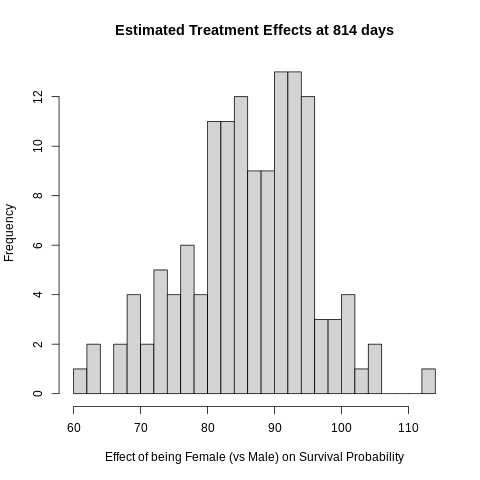

In [11]:
%%R
# Visualize estimated treatment effects
hist(tau_hat$predictions, breaks = 20,
     main = sprintf("Estimated Treatment Effects at %.0f days", last_valid_ht),
     xlab = "Effect of being Female (vs Male) on Survival Probability")

# Mean treatment effect
cat("Mean estimated treatment effect:", mean(tau_hat$predictions), "\n")

### Make Predictions

Predict the treatment effect for each patient (difference in RMST, in days).

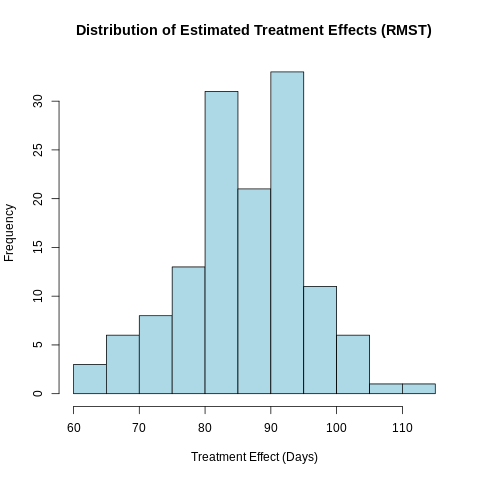

In [12]:
%%R
# Predict treatment effects (out-of-bag predictions)
csf_pred <- predict(csf_model)

# Plot a histogram of the estimated treatment effects
hist(csf_pred$predictions, main = "Distribution of Estimated Treatment Effects (RMST)",
     xlab = "Treatment Effect (Days)", col = "lightblue")

### Estimate the Average Treatment Effect

Compute the average treatment effect (ATE) across all patients.

In [13]:
%%R
# Estimate the average treatment effect
ate <- average_treatment_effect(csf_model)
ate

estimate  std.err 
89.04473 48.46362 


### Assess Heterogeneity

Evaluate treatment effect heterogeneity using the Average Treatment effect on the Ordered Characteristic (AUTOC) and plot the Treatment Outcome Curve (TOC).


AUTOC: -31.32 +/- 119.48 


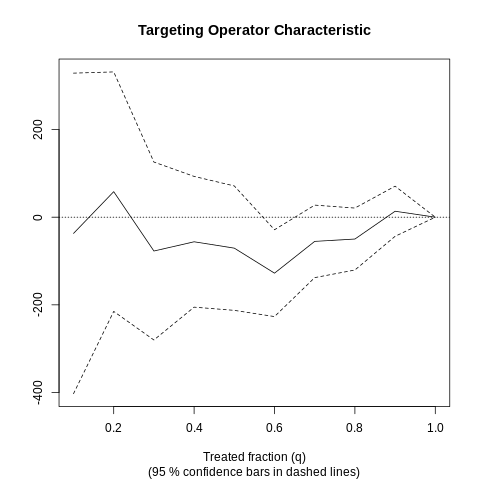

In [14]:
%%R
# Split data into training and evaluation sets
n <- nrow(X)
train_idx <- sample(1:n, n / 2)
eval_idx <- setdiff(1:n, train_idx)

# Train forests on training and evaluation sets
train_csf <- causal_survival_forest(
  X[train_idx, ], Y[train_idx], W[train_idx], D[train_idx],
  horizon = last_valid_ht, seed = 123
)
eval_csf <- causal_survival_forest(
  X[eval_idx, ], Y[eval_idx], W[eval_idx], D[eval_idx],
  horizon = last_valid_ht, seed = 123
)

# Compute AUTOC and plot TOC
rate <- rank_average_treatment_effect(eval_csf, predict(train_csf, X[eval_idx, ])$predictions)
plot(rate)
cat("AUTOC:", round(rate$estimate, 2), "+/-", round(1.96 * rate$std.err, 2), "\n")

### Variable Importnace

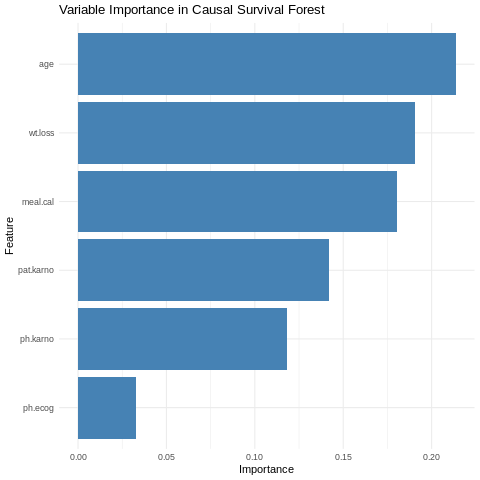

In [15]:
%%R
var_importance <- variable_importance(csf_model)
features <- colnames(X_train)

# Create a data frame for plotting
importance_df <- data.frame(
  Feature = features,
  Importance = var_importance
)

# Create bar plot with ggplot2
ggplot(importance_df, aes(x = reorder(Feature, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +  # Flip coordinates for better readability
  labs(title = "Variable Importance in Causal Survival Forest",
       x = "Feature",
       y = "Importance") +
  theme_minimal()

## Summary and Conclusion

This notebook demonstrated how to use the **Causal Survival Forest (CSF)** from the `{grf}` package in R to estimate heterogeneous treatment effects on survival data, particularly when outcomes are right-censored. The CSF allows for flexible, non-parametric estimation of treatment effects while accounting for censoring, making it a powerful tool for analyzing survival data in various fields. The example used the `lung` dataset to illustrate how to prepare the data, train a CSF model, predict treatment effects, and assess treatment effect heterogeneity. The results showed how the CSF can provide insights into how different covariates influence treatment effects on survival outcomes.

## References


1.  Cui, Y., Kosorok, M. R., Sverdrup, E., Wager, S., & Zhu, R. (2023). Estimating Heterogeneous Treatment Effects with Right-Censored Data via Causal Survival Forests. *Journal of the Royal Statistical Society: Series B*, 85(2).

2.  Sverdrup, E., & Wager, S. (2024). Treatment Heterogeneity with Right-Censored Outcomes Using grf. *ASA Lifetime Data Science Newsletter*.[(https://search.r-project.org/CRAN/refmans/grf/html/causal_survival_forest.html)}

3.  [grf Causal Survival Forest documentation](https://grf-labs.github.io/grf/articles/causal_survival_forest.html)

4.  [Original Causal Survival Forests paper](https://arxiv.org/abs/2006.09639)

